In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
# --- Parameters ---
num_cells = 180
timesteps = 100
sigma = 40              # Width of ADN input bump
dt = 1.0
tau = 50.0              # Decay time constant
gamma = 5.0             # Global inhibition
xi = 0.5                # % noise for path integration
step_size = 5.0         # Random walk step size for true head direction

In [3]:
# Preferred directions
preferred_directions = np.linspace(0, 360, num_cells, endpoint=False)
theta = np.deg2rad(preferred_directions)

In [4]:
def circular_gaussian(x, mu, sigma):
    delta = np.angle(np.exp(1j * np.deg2rad(x - mu)), deg=True)
    return np.exp(-0.5 * (delta / sigma) ** 2)

In [5]:
# --- Initialization ---
true_hd = 0.0
x_est = 0.0  # Estimated by ADN
activity = circular_gaussian(preferred_directions, x_est, sigma)

In [7]:
# Tracking data
activity_over_time = [activity.copy()]
firing_rate_over_time = [np.maximum(0, np.tanh(activity))]
true_hd_over_time = [true_hd]
x_est_over_time = [x_est]
tracking_error_over_time = []

# --- Simulation loop ---
for t in range(1, timesteps):
    # Update true head direction (random walk)
    delta = np.random.uniform(-step_size, step_size)
    true_hd = (true_hd + delta) % 360
    true_hd_over_time.append(true_hd)

    # Add noisy estimation
    noise = np.random.normal(loc=xi * delta, scale=xi * abs(delta))
    x_est = (true_hd + noise) % 360
    x_est_over_time.append(x_est)

    # Input bump centered at x_est
    input_bump = circular_gaussian(preferred_directions, x_est, sigma)

    # Inhibition and decay
    firing_rate = np.maximum(0, np.tanh(activity))
    inhibition = gamma * np.mean(firing_rate)
    decay = (dt / tau) * activity

    # Update activation
    activity = activity + input_bump - inhibition - decay
    activity = np.clip(activity, 0, None)

    # Firing rate
    firing_rate = np.maximum(0, np.tanh(activity))
    firing_rate_over_time.append(firing_rate.copy())

    # Compute bump center (population vector)
    cos_sum = np.sum(firing_rate * np.cos(np.deg2rad(preferred_directions)))
    sin_sum = np.sum(firing_rate * np.sin(np.deg2rad(preferred_directions)))
    bump_dir = (np.rad2deg(np.arctan2(sin_sum, cos_sum))) % 360

    # Error vs true head direction
    error = np.angle(np.exp(1j * np.deg2rad(bump_dir - true_hd)), deg=True)
    tracking_error_over_time.append(error)

activity_over_time = np.array(activity_over_time)
firing_rate_over_time = np.array(firing_rate_over_time)

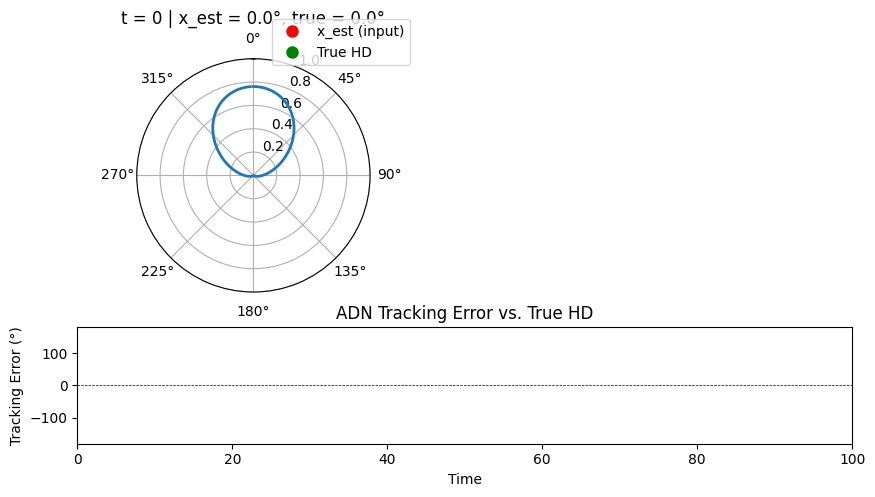

In [8]:
# --- Plotting ---
fig = plt.figure(figsize=(10, 5))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 0.5])

# Polar plot
ax_polar = fig.add_subplot(gs[0, 0], polar=True)
ax_polar.set_theta_zero_location("N")
ax_polar.set_theta_direction(-1)
ax_polar.set_rlim(0, 1.0)
line, = ax_polar.plot([], [], lw=2)
marker_est, = ax_polar.plot([], [], 'ro', label='x_est (input)', markersize=8)
marker_true, = ax_polar.plot([], [], 'go', label='True HD', markersize=8)
ax_polar.legend(loc='upper right', bbox_to_anchor=(1.2, 1.2))

# Error plot
ax_error = fig.add_subplot(gs[1, :])
ax_error.set_xlim(0, timesteps)
ax_error.set_ylim(-180, 180)
ax_error.set_xlabel("Time")
ax_error.set_ylabel("Tracking Error (°)")
ax_error.set_title("ADN Tracking Error vs. True HD")
line_error, = ax_error.plot([], [], 'm-')
ax_error.axhline(0, color='k', linestyle='--', linewidth=0.5)

# --- Animation update ---
def update(frame):
    rate = firing_rate_over_time[frame]
    line.set_data(theta, rate)
    marker_est.set_data([np.deg2rad(x_est_over_time[frame])], [1.05])
    marker_true.set_data([np.deg2rad(true_hd_over_time[frame])], [1.05])
    ax_polar.set_title(f"t = {frame} | x_est = {x_est_over_time[frame]:.1f}°, true = {true_hd_over_time[frame]:.1f}°")

    x_vals = np.arange(1, frame + 1)
    line_error.set_data(x_vals, tracking_error_over_time[:frame])
    return line, marker_est, marker_true, line_error

ani = animation.FuncAnimation(
    fig, update,
    frames=timesteps,
    interval=100,
    blit=False,
    repeat=False
)

ani.save('plot_ani/adn_hd.gif', writer='pillow', fps=20);